In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload your Kaggle API credentials
uploaded = files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair -p /content/anime_dataset

100% 11.6G/11.6G [06:25<00:00, 35.7MB/s]
100% 11.6G/11.6G [06:25<00:00, 32.4MB/s]


In [ ]:
!unzip /content/anime_dataset/anime-sketch-colorization-pair.zip -d /content/anime_dataset

In [ ]:
!unzip /content/border_dataset.zip -d /content/border_dataset

In [ ]:
!cp /content/drive/MyDrive/datasets/AbsKidsImg2Line.zip /content
!cp /content/drive/MyDrive/datasets/AbsKidsTextImg2Line.zip /content
!cp /content/drive/MyDrive/datasets/AbsOtherImg2Line.zip /content

In [ ]:
!unzip /content/AbsKidsImg2Line.zip -d /content
!unzip /content/AbsKidsTextImg2Line.zip -d /content
!unzip /content/AbsOtherImg2Line.zip -d /content

### Preprocess datasets

In [ ]:
from PIL import Image

In [ ]:
!cp /content/drive/MyDrive/datasets/AbsKidsTransformed.zip /content/
!cp /content/drive/MyDrive/datasets/AbsKidsTextTransformed.zip /content/
!cp /content/drive/MyDrive/datasets/AbsOtherTransformed.zip /content/

In [ ]:
!mkdir /content/AbsKidsTransformed/
!mkdir /content/AbsKidsTextTransformed/
!mkdir /content/AbsOtherTransformed/

In [ ]:
!unzip /content/AbsKidsTransformed.zip -d /content/AbsKidsTransformed/
!unzip /content/AbsKidsTextTransformed.zip -d /content/AbsKidsTextTransformed/
!unzip /content/AbsOtherTransformed.zip -d /content/AbsOtherTransformed/

In [ ]:
!mkdir /content/AbsKidsTransformedDataset/
!mkdir /content/AbsKidsTextTransformedDataset/
!mkdir /content/AbsOtherTransformedDataset/

In [ ]:
import os

In [ ]:
file_list = os.listdir("/content/AbsKidsTextTransformed/content/AbsKidsText/content/AbsKidsText/Kids with text/")

path_arr = []
for file_name in file_list:
    path_arr.append(file_name)

print(path_arr.__len__())

39


In [ ]:
for i, path in enumerate(path_arr):
    img_source = Image.open(f"/content/AbsKidsTextTransformed/content/AbsKidsText/content/AbsKidsText/Kids with text/{path}")
    print(img_source.size)
    img_processed = Image.open(f"/content/AbsKidsTextTransformed/content/AbsKidsText/content/AbsKidsText/Img2LineKidsText/{path}")
    img_processed = img_processed.resize(img_source.size)
    print(img_processed.size)
    if i == 1:
        break
    #img.save(f"/content/AbsKidsTextTransformedDataset/{path}")

(1920, 1080)
(1920, 1080)
(1024, 1024)
(1024, 1024)


In [ ]:
img_source

In [ ]:
img_processed

### Model

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.utils import save_image

from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# set parameters
DEVICE = 'cuda'
LEARNING_RATE = 2e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 512
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 12
SAVE_PER_EPOCHS = 1
SAVE_MODEL = True
LOAD_MODEL = False
CHECKPOINT_DISC = 'disc.pth.tar'
CHECKPOINT_GEN = 'gen.pth.tar'

In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE),y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * .5 + .5 # remove normalization
        save_image(y_fake, folder + f'/y_gen_{epoch}.png')
        if epoch == 0:
            # only the first epoch will save label and input sketch
            save_image(y * .5 + .5, folder+ f'/label_{epoch}.png')
            save_image(x * .5 + .5, folder + f'/input_{epoch}.png')
    gen.train()

def save_checkpoint(model, optimizer, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict':model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    # load saved checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# CNN block will be used repeatly later
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
# x, y <- concatenate the gen image and the input image to determin the gen image is real or not
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0],kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(.2)
        )

        # save layers into a list
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        # append last conv layer
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
        )

        # create a model using the list of layers
        self.model = nn.Sequential(*layers)
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [ ]:
# test the output of discriminator
x = torch.randn((1, 3, 512, 512))
y = torch.randn((1, 3, 512, 512))
model = Discriminator()
preds = model(x, y)
print(preds.shape)

torch.Size([1, 1, 58, 58])


In [ ]:
!pip install torchviz torchinfo

In [ ]:
print(model)

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
from torchsummary import summary
model = model
summary(model, input_size=[(3, 512, 1024), (3, 512, 1024)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]           6,208
         LeakyReLU-2         [-1, 64, 256, 512]               0
            Conv2d-3        [-1, 128, 127, 255]         131,072
       BatchNorm2d-4        [-1, 128, 127, 255]             256
         LeakyReLU-5        [-1, 128, 127, 255]               0
          CNNBlock-6        [-1, 128, 127, 255]               0
            Conv2d-7         [-1, 256, 62, 126]         524,288
       BatchNorm2d-8         [-1, 256, 62, 126]             512
         LeakyReLU-9         [-1, 256, 62, 126]               0
         CNNBlock-10         [-1, 256, 62, 126]               0
           Conv2d-11         [-1, 512, 59, 123]       2,097,152
      BatchNorm2d-12         [-1, 512, 59, 123]           1,024
        LeakyReLU-13         [-1, 512, 59, 123]               0
         CNNBlock-14         [-1, 512, 

In [ ]:
# block will be use repeatly later
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            # the block will be use on both encoder (down=True) and decoder (down=False)
            nn.Conv2d(in_channels, out_channels, 4,2,1,bias=False, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4,2,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(.5)
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        # Encoder
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4,2,1, padding_mode='reflect'),
            nn.LeakyReLU(.2),
        )
        self.down1 = Block(features, features*2, down=True,act='leaky',use_dropout=False) #64
        self.down2 = Block(features*2, features*4, down=True,act='leaky',use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True,act='leaky',use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4,2,1,padding_mode='reflect'),
            nn.ReLU(), # 1x1
        )
        # Decoder
        self.up1 = Block(features*8, features*8, down=False,act='relu',use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False,act='relu',use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False,act='relu',use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False,act='relu',use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        # Encoder
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)

        # Decoder
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1,d7],1))
        u3 = self.up3(torch.cat([u2,d6],1))
        u4 = self.up4(torch.cat([u3,d5],1))
        u5 = self.up5(torch.cat([u4,d4],1))
        u6 = self.up6(torch.cat([u5,d3],1))
        u7 = self.up7(torch.cat([u6,d2],1))
        return self.final_up(torch.cat([u7, d1],1))

In [ ]:
# test the output of Generator
x = torch.randn((1, 3, 512, 1024))
model = Generator(in_channels=3, features=64)
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 512, 1024])


In [ ]:
print(model)

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [ ]:
from torchviz import make_dot

make_dot(preds.mean(), params=dict(model.named_parameters())).render("Generator_scheme", format="png")

'Generator_scheme.png'

In [ ]:
print(model)

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
from torchsummary import summary
model = model
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
         LeakyReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3        [-1, 128, 128, 128]         131,072
       BatchNorm2d-4        [-1, 128, 128, 128]             256
         LeakyReLU-5        [-1, 128, 128, 128]               0
             Block-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         524,288
       BatchNorm2d-8          [-1, 256, 64, 64]             512
         LeakyReLU-9          [-1, 256, 64, 64]               0
            Block-10          [-1, 256, 64, 64]               0
           Conv2d-11          [-1, 512, 32, 32]       2,097,152
      BatchNorm2d-12          [-1, 512, 32, 32]           1,024
        LeakyReLU-13          [-1, 512, 32, 32]               0
            Block-14          [-1, 512,

In [ ]:
# Data Augmentation
class Transforms():
    def __init__(self):
        # use on both sketchs and colored images
        self.both_transform = A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=.5)
        ],additional_targets={'image0':'image'})

        # use on sketchs only
        self.transform_only_input = A.Compose([
            A.ColorJitter(p=.1),
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])

        # use on colored images
        self.transform_only_mask = A.Compose([
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])

In [ ]:
# Sketchs and Colored Image dataset
class AnimeDataset(Dataset):
    def __init__(self,root_dir,transforms):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.transform = transforms

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        # read image file
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))

        # divide image into sketchs and colored_imgs, right is sketch and left is colored images
        sketchs = image[:,image.shape[1]//2:,:]
        colored_imgs = image[:,:image.shape[1]//2,:]

        # data augmentation on both sketchs and colored_imgs
        augmentations = self.transform.both_transform(image=sketchs, image0=colored_imgs)
        sketchs, colored_imgs = augmentations['image'], augmentations['image0']

        # conduct data augmentation respectively
        sketchs = self.transform.transform_only_input(image=sketchs)['image']
        colored_imgs = self.transform.transform_only_mask(image=colored_imgs)['image']
        #return sketchs, colored_imgs
        return colored_imgs, sketchs

In [ ]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    G_fake_loss_arr = []
    L1_loss_arr = []
    G_loss_arr = []
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.cuda.amp.autocast():
            # generate fake colored imgs
            y_fake = gen(x)
            # validate real and fake imgs using discriminator
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            # calculate fake and real discriminator loss
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            # calculate average discriminator loss of fake and real colored image
            D_loss = (D_real_loss + D_fake_loss) / 2
        # update weight
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
            G_fake_loss_arr.append(G_fake_loss.item())
            L1_loss_arr.append(L1.item())
            G_loss_arr.append(G_loss.item())
        opt_gen.zero_grad()
        d_scaler.scale(G_loss).backward()
        d_scaler.step(opt_gen)
        d_scaler.update()

    G_fake_loss_arr = np.array(G_fake_loss_arr).mean()
    L1_loss_arr = np.array(L1_loss_arr).mean()
    G_loss_arr = np.array(G_loss_arr).mean()
    return G_fake_loss_arr, L1_loss_arr, G_loss_arr

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# check how to load border dataset
transforms = Transforms()
train_anime_dataset = AnimeDataset(root_dir='/content/anime_dataset/data/train/',transforms=transforms)
val_dataset = AnimeDataset(root_dir='/content/anime_dataset/data/val/',transforms=transforms)

train_border_dataset = AnimeDataset(root_dir='/content/border_dataset/content/border_dataset',transforms=transforms)

train_abskids_dataset = AnimeDataset(root_dir='/content/content/AbsKids/Img2LineKids',transforms=transforms)
train_abskidstext_dataset = AnimeDataset(root_dir='/content/content/AbsKidsText/Img2LineKidsText',transforms=transforms)
train_other_dataset = AnimeDataset(root_dir='/content/content/AbsOther/Img2LineOther',transforms=transforms)

# make val part of train_border_dataset
train_border_dataset_split, val_border_dataset = train_test_split(train_border_dataset, train_size=0.9, test_size=0.1, random_state=42)

train_abskids_dataset, val_abskids_dataset = train_test_split(train_abskids_dataset, train_size=0.9, test_size=0.1, random_state=42)
train_abskidstext_dataset, val_abskidstext_dataset = train_test_split(train_abskidstext_dataset, train_size=0.9, test_size=0.1, random_state=42)
train_other_dataset, val_other_dataset = train_test_split(train_other_dataset, train_size=0.9, test_size=0.1, random_state=42)

print(train_anime_dataset.__len__(), val_dataset.__len__())
print(train_border_dataset_split.__len__(), val_border_dataset.__len__())

print(train_abskids_dataset.__len__(), val_abskids_dataset.__len__())
print(train_abskidstext_dataset.__len__(), val_abskidstext_dataset.__len__())
print(train_other_dataset.__len__(), val_other_dataset.__len__())

14224 3545
90 10
90 10
31 4
15 2


In [ ]:
train_dataset = torch.utils.data.ConcatDataset([train_anime_dataset, train_border_dataset_split])
val_dataset = torch.utils.data.ConcatDataset([val_dataset, val_border_dataset])

In [ ]:
val_loader_border = DataLoader(val_border_dataset, batch_size=1, shuffle=False)
for i, (x, y) in enumerate(val_loader_border):
    image_np_x = x[0].cpu().numpy().transpose(1, 2, 0)
    image_np_y = y[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image_np_x)
    plt.axis('off')
    plt.show()
    plt.imshow(image_np_y)
    plt.axis('off')
    plt.show()
    # if i == 5:
    #     break

In [ ]:
val_loader_anime = DataLoader(val_dataset, batch_size=1, shuffle=False)
for i, (x, y) in enumerate(val_loader_anime):
    image_np_x = x[0].cpu().numpy().transpose(1, 2, 0)
    image_np_y = y[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image_np_x)
    plt.axis('off')
    plt.show()
    plt.imshow(image_np_y)
    plt.axis('off')
    plt.show()
    if i == 5:
        break

In [ ]:
val_loader_border.__len__()

10

In [ ]:
def run():
    # model
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    # optimizer
    opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE, betas=(.5,.999))
    opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(.5,.999))
    # loss
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    # load trained weight
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

    # train dataset
    transforms = Transforms()

    train_anime_dataset = AnimeDataset(root_dir='/content/anime_dataset/data/train/',transforms=transforms)
    val_anime_dataset = AnimeDataset(root_dir='/content/anime_dataset/data/val/',transforms=transforms)
    train_border_dataset = AnimeDataset(root_dir='/content/border_dataset/content/border_dataset',transforms=transforms)
    train_abskids_dataset = AnimeDataset(root_dir='/content/content/AbsKids/Img2LineKids',transforms=transforms)
    train_abskidstext_dataset = AnimeDataset(root_dir='/content/content/AbsKidsText/Img2LineKidsText',transforms=transforms)
    train_other_dataset = AnimeDataset(root_dir='/content/content/AbsOther/Img2LineOther',transforms=transforms)

    train_border_dataset_split, val_border_dataset = train_test_split(train_border_dataset, train_size=0.9, test_size=0.1, random_state=42)
    train_abskids_dataset, val_abskids_dataset = train_test_split(train_abskids_dataset, train_size=0.9, test_size=0.1, random_state=42)
    train_abskidstext_dataset, val_abskidstext_dataset = train_test_split(train_abskidstext_dataset, train_size=0.9, test_size=0.1, random_state=42)
    train_other_dataset, val_other_dataset = train_test_split(train_other_dataset, train_size=0.9, test_size=0.1, random_state=42)

    train_dataset = torch.utils.data.ConcatDataset([train_anime_dataset, train_border_dataset_split, train_abskids_dataset, train_abskidstext_dataset, train_other_dataset])
    val_dataset = torch.utils.data.ConcatDataset([val_anime_dataset, val_border_dataset, val_abskids_dataset, val_abskidstext_dataset, val_other_dataset])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    # val dataset
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    if not os.path.exists('evaluation/'):
        os.makedirs('evaluation/')

    G_fake_loss_arr, L1_loss_arr, G_loss_arr = [], [], []
    for epoch in range(NUM_EPOCHS):
        G_fake_loss, L1_loss, G_loss = train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] G_fake_loss: {G_fake_loss:.4f}, L1_loss: {L1_loss:.4f}, G_loss: {G_loss:.4f}')
        G_fake_loss_arr.append(G_fake_loss)
        L1_loss_arr.append(L1_loss)
        G_loss_arr.append(G_loss)
        # save model weight per SAVE_PER_EPOCHS
        if SAVE_MODEL and epoch % SAVE_PER_EPOCHS == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
        save_some_examples(gen,val_loader, epoch, folder='evaluation')

    return gen, disc, G_fake_loss_arr, L1_loss_arr, G_loss_arr

In [ ]:
gen, disc, G_fake_loss_arr, L1_loss_arr, G_loss_arr = run()

100%|██████████| 452/452 [01:37<00:00,  4.65it/s]


Epoch [1/12] G_fake_loss: 1.2445, L1_loss: 12.6548, G_loss: 13.8993
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:31<00:00,  4.91it/s]


Epoch [2/12] G_fake_loss: 0.9599, L1_loss: 6.8048, G_loss: 7.7647
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:36<00:00,  4.68it/s]


Epoch [3/12] G_fake_loss: 0.9163, L1_loss: 5.9615, G_loss: 6.8779
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:31<00:00,  4.95it/s]


Epoch [4/12] G_fake_loss: 0.8984, L1_loss: 5.4898, G_loss: 6.3882
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:33<00:00,  4.82it/s]


Epoch [5/12] G_fake_loss: 0.9469, L1_loss: 5.1766, G_loss: 6.1234
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:39<00:00,  4.56it/s]


Epoch [6/12] G_fake_loss: 0.9677, L1_loss: 4.9611, G_loss: 5.9288
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:37<00:00,  4.62it/s]


Epoch [7/12] G_fake_loss: 0.9637, L1_loss: 4.8278, G_loss: 5.7916
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:33<00:00,  4.81it/s]


Epoch [8/12] G_fake_loss: 1.0094, L1_loss: 4.6935, G_loss: 5.7030
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:37<00:00,  4.64it/s]


Epoch [9/12] G_fake_loss: 1.0136, L1_loss: 4.5486, G_loss: 5.5622
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:38<00:00,  4.59it/s]


Epoch [10/12] G_fake_loss: 1.1628, L1_loss: 4.6835, G_loss: 5.8463
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:33<00:00,  4.83it/s]


Epoch [11/12] G_fake_loss: 1.0545, L1_loss: 4.6062, G_loss: 5.6606
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 452/452 [01:37<00:00,  4.61it/s]


Epoch [12/12] G_fake_loss: 1.0727, L1_loss: 4.4217, G_loss: 5.4945
=> Saving checkpoint
=> Saving checkpoint


In [ ]:
# save gen sample image into a list
imgs = []
for i in os.listdir('./evaluation'):
    if i[:5] == 'y_gen':
        img = plt.imread(os.path.join('./evaluation',i))
        imgs.append(img)

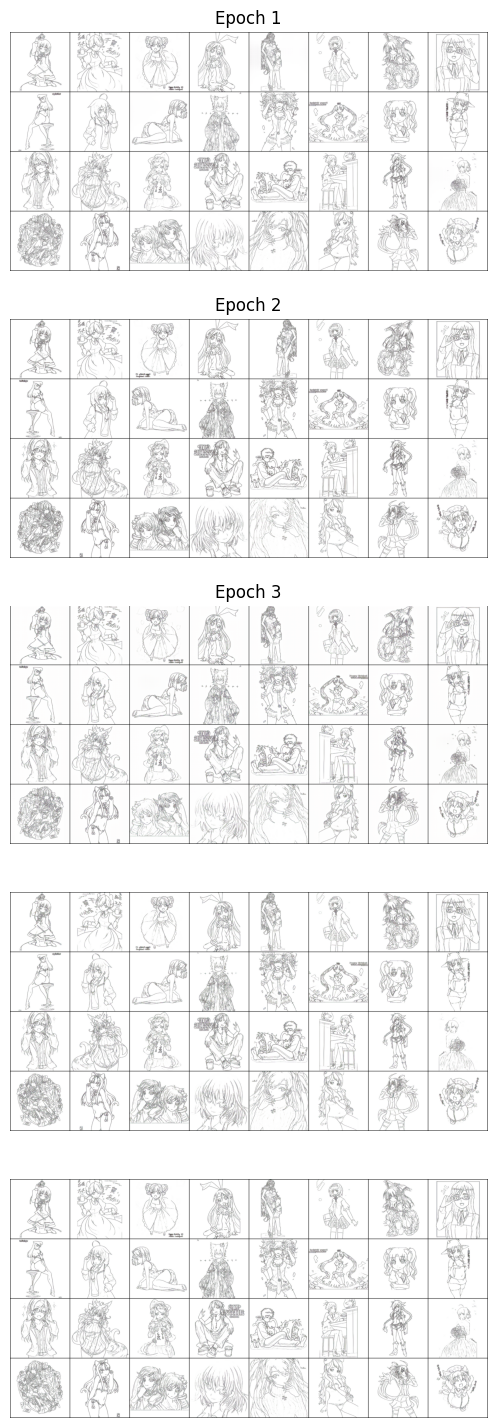

In [ ]:
# visualize list of sample images
fig, axs = plt.subplots(5,1,figsize=(18,18))
[ax.imshow(img) for ax,img in zip(axs.ravel(),imgs)]
[ax.axis('off') for ax in axs.ravel()]
[ax.set_title(f'Epoch {i}') for ax, i in zip(axs.ravel(),range(1,4))];

In [ ]:
# !mkdir ./test_dump_train_images/
# !mkdir ./test_dump_train_images/no_class
# !cp /content/anime_dataset/data/train/* ./test_dump_train_images/no_class/

In [ ]:
# import torchvision.transforms as transforms
# transform_check = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # show size of train dataset
# dataset = ImageFolder(root='/content/test_dump_train_images/', transform=transform_check)

# data_loader = DataLoader(dataset, batch_size=1)

In [ ]:
# image_sizes_1 = []
# image_sizes_2 = []
# for img1, img2 in tqdm(data_loader, position=0, leave=True):
#     image_sizes_1.append(img1.shape)
#     image_sizes_2.append(img2.shape)

### Evaluation and Inference

In [ ]:
transforms = Transforms()
#val_dataset = AnimeDataset(root_dir='/content/anime_dataset/data/val/',transforms=transforms)

# train_border_dataset = AnimeDataset(root_dir='/content/border_dataset/content/border_dataset',transforms=transforms)
# train_border_dataset_split, val_dataset = train_test_split(train_border_dataset, train_size=0.9, test_size=0.1, random_state=42)

# train_abskids_dataset = AnimeDataset(root_dir='/content/content/AbsKids/Img2LineKids',transforms=transforms)
# train_abskids_dataset, val_dataset = train_test_split(train_abskids_dataset, train_size=0.9, test_size=0.1, random_state=42)

# train_abskidstext_dataset = AnimeDataset(root_dir='/content/content/AbsKidsText/Img2LineKidsText',transforms=transforms)
# train_abskidstext_dataset, val_dataset = train_test_split(train_abskidstext_dataset, train_size=0.5, test_size=0.5, random_state=42)

train_other_dataset = AnimeDataset(root_dir='/content/content/AbsOther/Img2LineOther',transforms=transforms)
train_other_dataset, val_dataset = train_test_split(train_other_dataset, train_size=0.5, test_size=0.5, random_state=42)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt

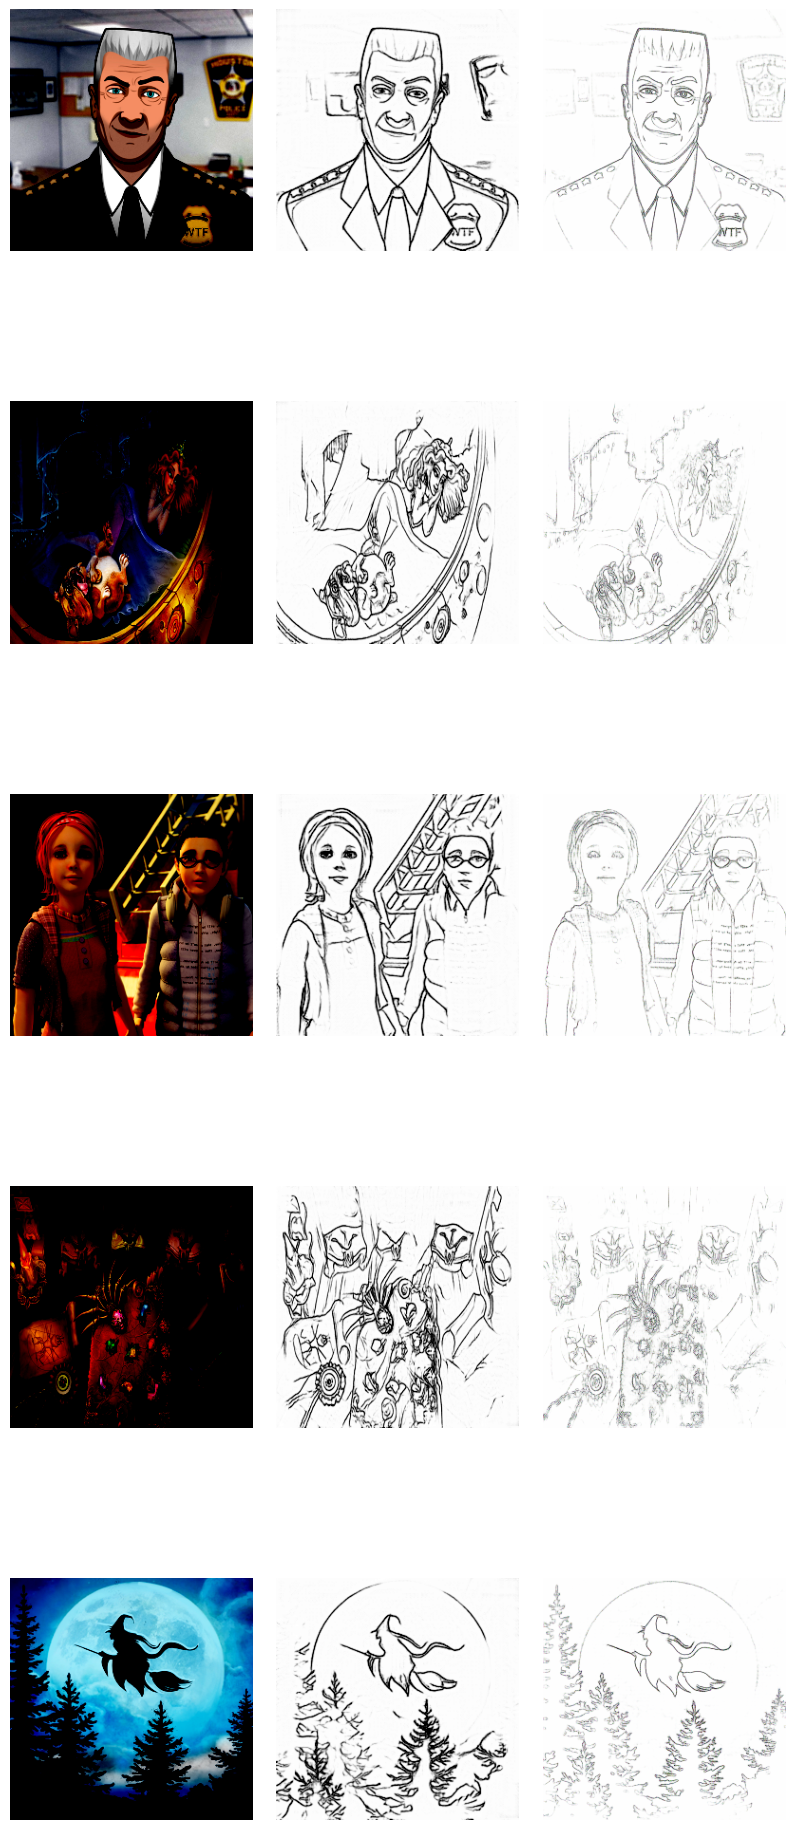

In [ ]:
# Create a figure with multiple subplots
num = 5
num_rows = num
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num))

for i, (x, y) in enumerate(val_loader):
    if i >= num:
        break


    # Convert the PyTorch tensors to NumPy arrays and transpose them
    image_np_x = x[0].cpu().numpy().transpose(1, 2, 0)
    image_np_y = y[0].cpu().numpy().transpose(1, 2, 0)

    # Calculate the row and column for the current subplot
    row = i
    col_x = 0
    col_y = 1
    col_pred = 2

    # Generate
    x_input, y_input = x[0].to(DEVICE).unsqueeze(0), y[0].to(DEVICE).unsqueeze(0)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x_input)
        y_fake = y_fake * .5 + .5 # remove normalization
        image_np_pred = y_fake[0].cpu().numpy().transpose(1, 2, 0)

    # Display the images in the corresponding subplots
    axes[row, col_x].imshow(image_np_x)
    axes[row, col_y].imshow(image_np_y)
    axes[row, col_pred].imshow(image_np_pred)

    # Turn off axis labels and ticks for both subplots
    axes[row, col_x].axis('off')
    axes[row, col_y].axis('off')
    axes[row, col_pred].axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the figure with 'num' pairs of images
plt.show()

In [ ]:
!rm -rf /content/slonik_dataset/.ipynb_checkpoints

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


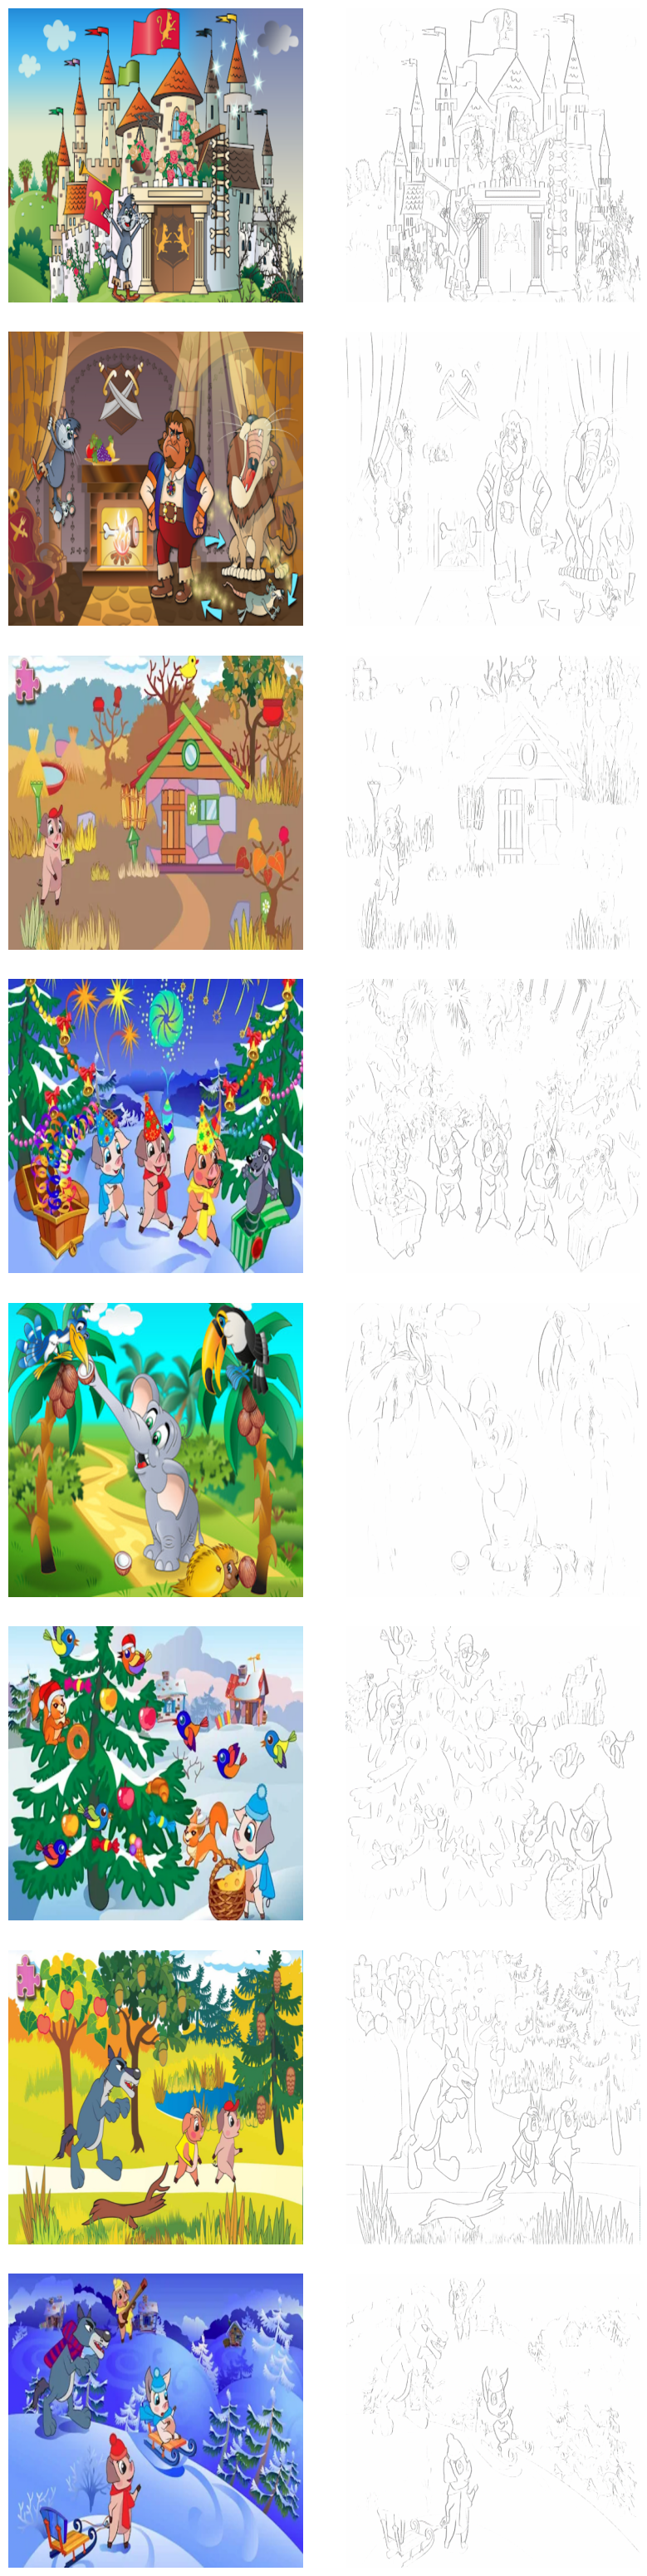

In [ ]:
# slonik
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define the transformation to resize and normalize the images
transform_slon = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = ImageFolder(root='/content/slonik_dataset', transform=transform_slon)

data_loader = DataLoader(dataset, batch_size=1)

num = 8
num_rows = num
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num))

for i, batch in enumerate(data_loader):
    row = i
    col_x = 0
    col_pred = 1

    images, labels = batch
    print(images.shape)
    x_input = images.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x_input)
        y_fake = y_fake * .5 + .5 # remove normalization
        image_np_pred = y_fake[0].cpu().numpy().transpose(1, 2, 0)

    image_np_x = images[0].cpu().numpy().transpose(1, 2, 0)
    # Display the images in the corresponding subplots
    axes[row, col_x].imshow(image_np_x)
    axes[row, col_pred].imshow(image_np_pred)

    # Turn off axis labels and ticks for both subplots
    axes[row, col_x].axis('off')
    axes[row, col_pred].axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the figure with 'num' pairs of images
plt.show()